In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from modules.StochasticProcess import StochasticProcess
from modules.BaselineWanderRemover import BaselineWanderRemover
from modules.QRSdetector import QRSdetector
from modules.ECGestimator import ECGestimator
from sklearn.decomposition import FastICA

In [3]:
def extract_stochastic_process(filename, num_realizations):
    df = pd.read_csv(filename, skiprows=2, header=None)
    realizations, labels = [], []
    for i in range (1,num_realizations+1):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        realizations.append(AECG_cleaned.astype(float))
        labels.append("AECG"+str(i))

    return realizations, labels

In [4]:
# PARAMETERS

# general
num_realizations = 4
sr = 1000 
colors = ['blue', 'green', 'orange', 'red']

# baseline_wander_remover
cutoff = 3
num_taps = 1000

# PLI remover

# upsampling
upsample_factor = 2
new_sr = sr * upsample_factor

# MQRS detection
maternal_template_duration = 0.10
maternal_threshold_factor = 0.5

# MECG canceller
maternal_P_wave_duration = 0.20
maternal_T_wave_duration = 0.40

# FQRS detection
fetal_duration_template = 0.10
fetal_threshold_factor = 0.3

# FECG detection
fetal_P_wave_duration = 0.20
fetal_T_wave_duration = 0.40

In [5]:
def sequential_analysis(S1, num_realizations, labels, colors, sr, gt):
    # Baseline Wander removal
    bwr = BaselineWanderRemover(sr, cutoff, num_taps+1)
    S2 = StochasticProcess(num_realizations, [bwr.highpass_fir_filter(r) for r in S1], labels, colors, sr)

    # PLI removal

    # upsampling
    S4 = S2.resample_process(new_sr)

    # MQRS detection
    MQRS_detector = QRSdetector(S4, maternal_template_duration, maternal_threshold_factor, new_sr)
    maternal_enhanced_QRS, _ = MQRS_detector.get_enhanced_QRS()
    maternal_qrs_template = MQRS_detector.create_qrs_template(maternal_enhanced_QRS)
    maternal_peaks, _ = MQRS_detector.detect_qrs(maternal_enhanced_QRS, maternal_qrs_template)

    # MECG estimation and cancellation
    MECG_estimator = ECGestimator(S4, maternal_P_wave_duration, maternal_template_duration, maternal_T_wave_duration, new_sr, labels)
    real_MECGs, real_MECGs_positions = MECG_estimator.get_real_ECGs(maternal_peaks)
    MECG_averages = MECG_estimator.get_ECG_averages(real_MECGs)
    mu_portions = MECG_estimator.get_mu_portions(MECG_averages)
    M_matrixes = MECG_estimator.get_M_matrixes(mu_portions)
    estimated_MECGs = MECG_estimator.get_estimated_ECGs(real_MECGs, M_matrixes, mu_portions)
    residual_realizations = []
    for i in range(num_realizations): 
        residual_realizations.append(MECG_estimator.cancel_ECG(S4.get_realization_by_index(i), real_MECGs_positions[labels[i]], real_MECGs[labels[i]], estimated_MECGs[labels[i]]))
    S5 = StochasticProcess(num_realizations, residual_realizations, labels, colors, new_sr)

    # FQRS detection
    gt_fetal_peaks = gt * upsample_factor
    FQRS_detector = QRSdetector(S5, fetal_duration_template, fetal_threshold_factor, new_sr)
    fetal_enhanced_QRS, _ = FQRS_detector.get_enhanced_QRS()
    fetal_QRS_template = FQRS_detector.create_qrs_template(fetal_enhanced_QRS)
    fetal_peaks, _ = FQRS_detector.detect_qrs(fetal_enhanced_QRS, fetal_QRS_template)

    # FECG estimation
    FECG_estimator = ECGestimator(S5, fetal_P_wave_duration, fetal_duration_template, fetal_T_wave_duration, new_sr, labels)
    FECG_averages = FECG_estimator.get_ECG_averages(FECG_estimator.get_real_ECGs(fetal_peaks)[0])
    gt_FECG_averages = FECG_estimator.get_ECG_averages(FECG_estimator.get_real_ECGs(gt_fetal_peaks)[0])
    S5 = StochasticProcess(num_realizations, [FECG_averages[label] for label in FECG_averages], labels, colors, new_sr)

    return fetal_peaks, S5

In [6]:
def ICA_analysis(S1, gt_peaks, component_to_choose=1):
    signal = []
    for realization in S1: signal.append(realization)

    # 1. Preprocessing: centra e normalizza il segnale
    signal -= np.mean(signal, axis=1, keepdims=True)  # Rimuovi la media (centra il segnale)
    signal /= np.std(signal, axis=1, keepdims=True)   # Standardizza il segnale

    # 2. Applicare ICA
    ica = FastICA(n_components=signal.shape[0], random_state=42)  # n_components = numero di canali
    independent_components = ica.fit_transform(signal.T).T  # Restituisce le componenti separate

    # 3. Visualizza le componenti indipendenti
    plt.figure(figsize=(12, 8))
    for i, component in enumerate(independent_components):
        plt.subplot(signal.shape[0], 1, i + 1)
        plt.plot(component)
        plt.title(f'Component {i+1}')
        #plt.xlim(20000, 25000)
    plt.tight_layout()
    plt.show()

    fecg_signal = independent_components[component_to_choose]

    ICA_template_duration = 0.1
    ICA_threshold_factor = 0.3
    ICA_sr = 1000
    ICA_QRS_detector = QRSdetector(S1, ICA_template_duration, ICA_threshold_factor, ICA_sr)
    # si tratta la prima componente come fetal_enhanced_QRS
    ICA_QRS_template = ICA_QRS_detector.create_qrs_template(fecg_signal)
    ICA_peaks, ICA_cross_corr = ICA_QRS_detector.detect_qrs(fecg_signal, ICA_QRS_template)

    corr_max = np.max(ICA_cross_corr)
    print(f"ICA QRS peaks detected: {len(ICA_peaks)}, with correlation threshold factor: {round(ICA_threshold_factor*100)} %")
    print(f"QRS peaks (ground truth): {len(gt_peaks)}")
    
    plt.figure(figsize=(14, 8))

    time = S1.timestamps

    # Enhanced QRS (with detected peaks)
    plt.subplot(2, 1, 1)
    plt.plot(time, fecg_signal, label="enhanced QRS")
    plt.scatter(time[ICA_peaks], fecg_signal[ICA_peaks], color='red', label="Detected ICA QRS", zorder=2)
    plt.scatter(time[gt_peaks], fecg_signal[gt_peaks], color='orange', label="Ground Truth QRS peaks", zorder=2)

    plt.legend()
    plt.xlabel("Time [s]")
    plt.xlim(18, 30)
    plt.ylabel("Amplitude")
    plt.grid()

    # Cross-correlation
    plt.subplot(2, 1, 2)
    plt.plot(time[:len(ICA_cross_corr)], ICA_cross_corr, label="Normalized ICA Cross Correlation")
    plt.axhline(y=ICA_threshold_factor*corr_max, color='red', linestyle='--', label="Threshold")
    plt.legend()
    plt.xlim(18, 30)
    plt.xlabel("Time [s]")
    plt.ylabel("Correlation")
    plt.grid()

    plt.tight_layout()
    plt.show()

    return ICA_peaks

# **Misurazione Performance**

#### 1) **Valutazione del FHR**
come riferimento del fetal heart rate (FHR) abbiamo i picchi di ground truth: se i picchi di groud truth sono, ad esempio, 120, vuol dire che è stato misurato empiricamente che il cuore del feto batteva a 120 bpm. 
Per misurare la qualità del FHR estratto bisogna applicare il QRS detection method ad un segnale contenente l'ECG fetale ottenuto con un metodo diverso rispetto a quello dell'approccio sequenziale. Dunque:
- SP -> BW_Remover -> [PLI_remover] -> **ICA** -> ICx -> QRS_detection -> ICA_peaks
- SP -> sequential_approach -> sequential_peaks

Quale dei due si avvicina di più a ground truth per ciascun processo? 

In [7]:
data_extension = ".csv"
gt_extension = ".fqrs.txt"
data_path = "../data/set-a-text"

csv_paths, gt_paths = [], []

for file in os.listdir(data_path):
    if file.endswith(data_extension): csv_paths.append(os.path.join(data_path, file))
    if file.endswith(gt_extension): gt_paths.append(os.path.join(data_path, file))

csv_paths = sorted(csv_paths)
gt_paths = sorted(gt_paths)

FHRs = {}

for i in range(len(csv_paths)):
    sp_path = csv_paths[i]
    gt_path = gt_paths[i]

    # fetal peaks (ground truth)
    with open(gt_path, 'r') as file: gt = np.array([int(line.strip()) for line in file])
    
    # realizations
    realizations, labels = extract_stochastic_process(sp_path, num_realizations)
    S1 = StochasticProcess(num_realizations, realizations, labels, colors, sr)

    # sequential analysis
    try:
        estimated_fetal_peaks, S5 = sequential_analysis(S1, num_realizations, labels, colors, sr, gt)
        FHRs[sp_path] = (len(estimated_fetal_peaks), len(gt))
        print(f"Succesfully estimated FHR for {sp_path}") 
    except:
        print(f">> Unable to estimate FHR for {sp_path}")        


Succesfully estimated FHR for ../data/set-a-text/a01.csv
Succesfully estimated FHR for ../data/set-a-text/a02.csv
Succesfully estimated FHR for ../data/set-a-text/a03.csv
Succesfully estimated FHR for ../data/set-a-text/a04.csv
Succesfully estimated FHR for ../data/set-a-text/a05.csv
Succesfully estimated FHR for ../data/set-a-text/a06.csv
Succesfully estimated FHR for ../data/set-a-text/a07.csv
Succesfully estimated FHR for ../data/set-a-text/a08.csv
Succesfully estimated FHR for ../data/set-a-text/a09.csv
Succesfully estimated FHR for ../data/set-a-text/a10.csv
Succesfully estimated FHR for ../data/set-a-text/a11.csv
Succesfully estimated FHR for ../data/set-a-text/a12.csv
Succesfully estimated FHR for ../data/set-a-text/a13.csv
Succesfully estimated FHR for ../data/set-a-text/a14.csv
Succesfully estimated FHR for ../data/set-a-text/a15.csv
Succesfully estimated FHR for ../data/set-a-text/a16.csv
Succesfully estimated FHR for ../data/set-a-text/a17.csv
Succesfully estimated FHR for .

In [8]:
for el in FHRs:
    print(f"{el} -> {FHRs[el]}")

../data/set-a-text/a01.csv -> (118, 145)
../data/set-a-text/a02.csv -> (102, 160)
../data/set-a-text/a03.csv -> (126, 128)
../data/set-a-text/a04.csv -> (128, 129)
../data/set-a-text/a05.csv -> (126, 129)
../data/set-a-text/a06.csv -> (68, 160)
../data/set-a-text/a07.csv -> (133, 130)
../data/set-a-text/a08.csv -> (75, 128)
../data/set-a-text/a09.csv -> (65, 130)
../data/set-a-text/a10.csv -> (147, 175)
../data/set-a-text/a11.csv -> (29, 140)
../data/set-a-text/a12.csv -> (135, 138)
../data/set-a-text/a13.csv -> (125, 126)
../data/set-a-text/a14.csv -> (120, 123)
../data/set-a-text/a15.csv -> (132, 134)
../data/set-a-text/a16.csv -> (38, 130)
../data/set-a-text/a17.csv -> (124, 132)
../data/set-a-text/a18.csv -> (24, 150)
../data/set-a-text/a19.csv -> (126, 127)
../data/set-a-text/a20.csv -> (115, 131)
../data/set-a-text/a21.csv -> (137, 145)
../data/set-a-text/a22.csv -> (79, 126)
../data/set-a-text/a23.csv -> (124, 126)
../data/set-a-text/a24.csv -> (121, 123)
../data/set-a-text/a25.

../data/set-a-text/a01.csv


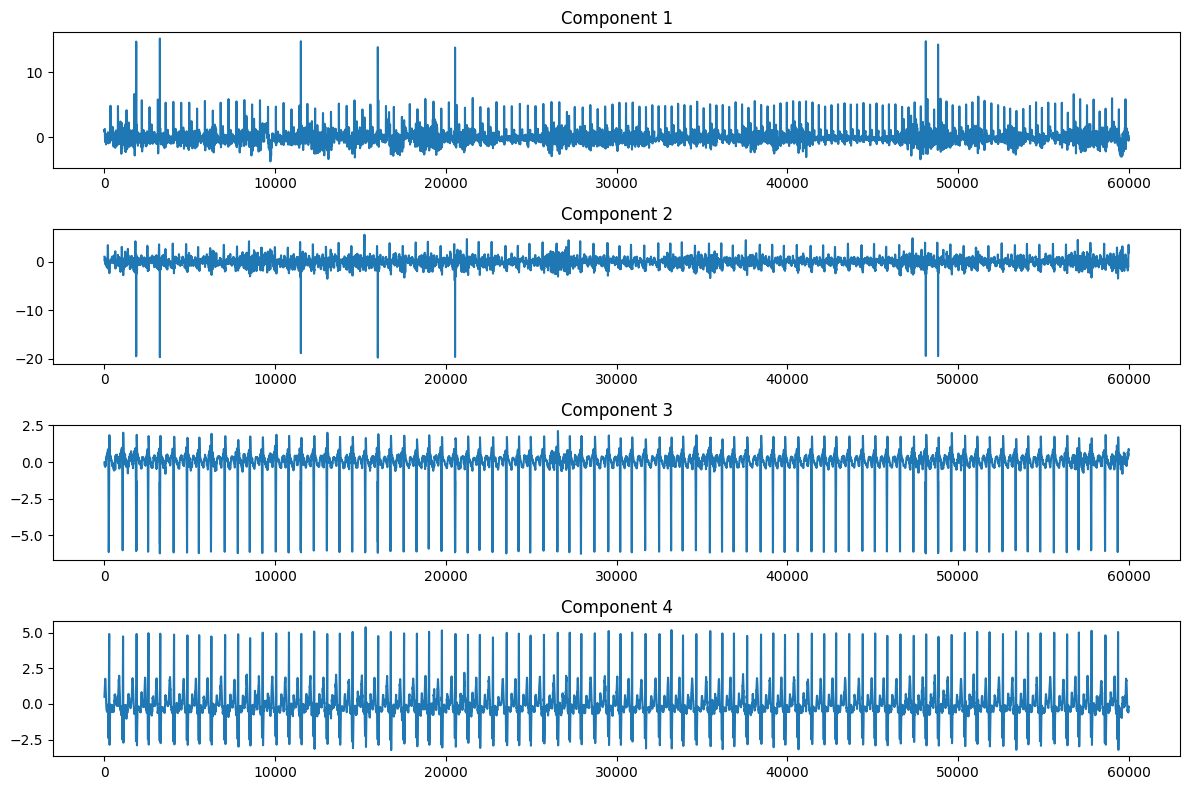

ICA QRS peaks detected: 80, with correlation threshold factor: 30 %
QRS peaks (ground truth): 145


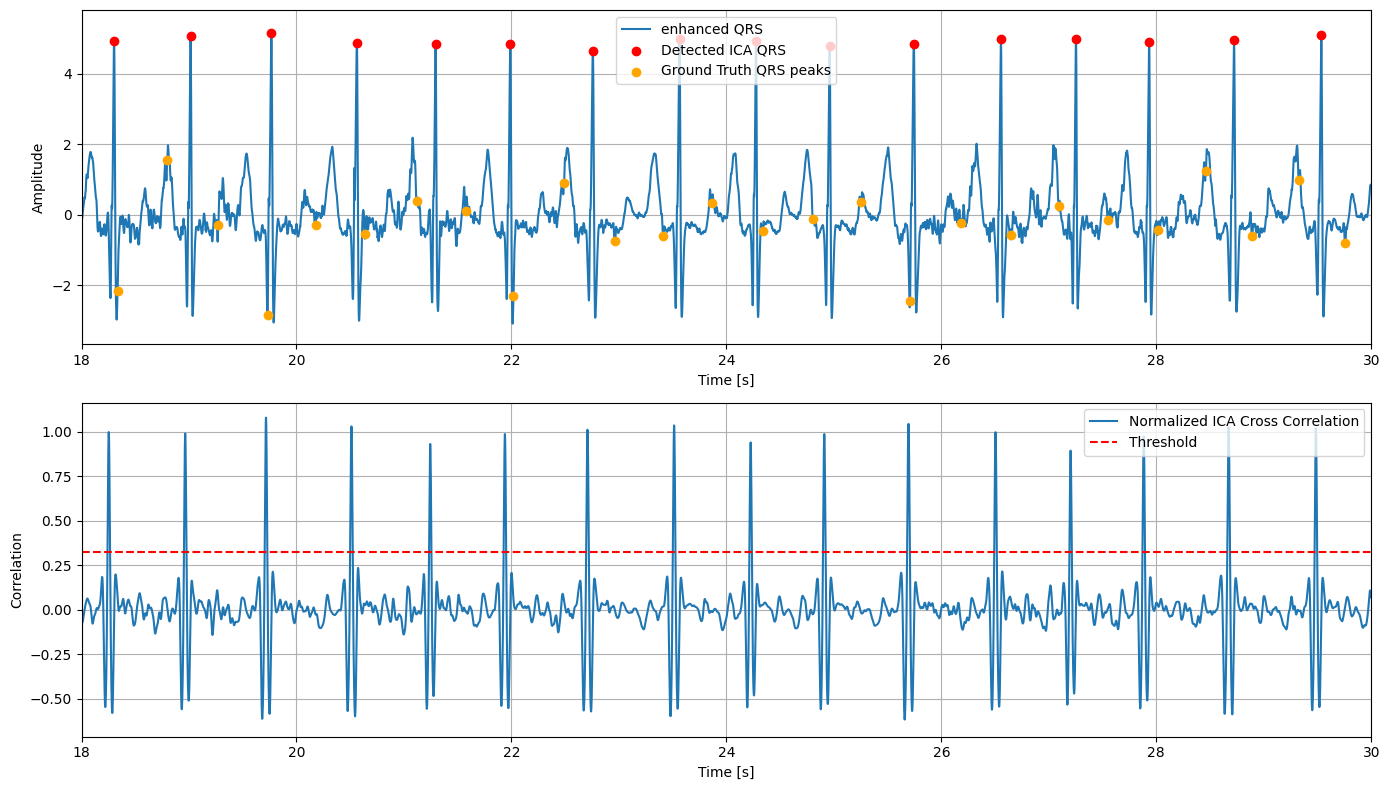

In [14]:
# TEST ICA

test = 0

sp_path = csv_paths[test]
gt_path = gt_paths[test]

print(sp_path)

# fetal peaks (ground truth)
with open(gt_path, 'r') as file: gt = np.array([int(line.strip()) for line in file])

# realizations
realizations, labels = extract_stochastic_process(sp_path, num_realizations)
S1 = StochasticProcess(num_realizations, realizations, labels, colors, sr)

ica_peaks = ICA_analysis(S1, gt, component_to_choose=3)



**Procedura di test**:

per ogni processo, verificare visualmente se i picchi ottenuti tramite ICA (per ogni componente) sono relativi ai picchi materni o fetali, 
guardando sia la differenza tra picchi stimati e picchi rilevati sull'enhanced QRS, sia la polarità dei complessi visualizzata nell'analisi sequenziale

- **a01**: 
    - la prima componente di ICA sembra far riferimento al segnale ECG fetale. I picchi di ground truth sono centrati su complessi QRS, e i picchi stimati da ICA si sovrappongono molto bene ad essi. *Picchi rilevati: 145/145*
    - l'approccio sequenziale stima un FECG rumoroso ma credibile. *Picchi rilevati: 118/145*

- **a02**:
    - 